# Example: Aeroelastic equilibrium

This notebook explains the process of model generation, simulation running and output analysis for an aeroelastic equilibrium simulation using ShARPy. In particular it uses a simplified workflow via the use of the 'Model Generator' which will be described below

In [1]:
import numpy as np
import os
import pdb
import importlib
import cases.models_generator.gen_main as gm
import sharpy.utils.algebra as algebra
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

model_route = os.getcwd()+'/example_equilibrium'

print(model_route)

/home/pablodfs/FYP/Projects-SHARPy/aeroelasticPMOR_Optimization/parametric_aircraft/example_equilibrium


## Model definition


In [2]:
# First some inputs
wing_semispan = 12 
bound_panels = 4 # This controls the chordwise discretisation of the aerogrid
components=['fuselage', 'wing_r', 'winglet_r',
                              'wing_l', 'winglet_l', 'vertical_tail',
                              'horizontal_tail_right', 'horizontal_tail_left']
# aeroelasticity parameters
main_ea = 0.3  # Wing elastic axis from LE as %
main_cg = 0.3  # Not sure about this input
sigma = 1.5
c_ref = 1.0

#########
# wings #
#########
#
ea = 1e7
ga = 1e5
gj = 1e4
eiy = 2e4
eiz = 4e6
m_bar_main = 0.75
j_bar_main = 0.075
mass_main1 = np.diag([m_bar_main, m_bar_main, m_bar_main,
                      j_bar_main, 0.5 * j_bar_main, 0.5 * j_bar_main])
stiffness_main1 = sigma * np.diag([ea, ga, ga, gj, eiy, eiz])
stiffness_main = np.zeros((1, 6, 6))
stiffness_main[0] = stiffness_main1
mass_main = np.zeros((1, 6, 6))
mass_main[0] = mass_main1
############
# fuselage #
############
#
sigma_fuselage = 10
m_bar_fuselage = 0.2
j_bar_fuselage = 0.08
stiffness_fuselage1 = np.diag([ea, ga, ga, gj, eiy, eiz]) * sigma * sigma_fuselage
stiffness_fuselage1[4, 4] = stiffness_fuselage1[5, 5]
mass_fuselage1 = np.diag([m_bar_fuselage,
                          m_bar_fuselage,
                          m_bar_fuselage,
                          j_bar_fuselage,
                          j_bar_fuselage * 0.5,
                          j_bar_fuselage * 0.5])
stiffness_fuselage = np.zeros((1, 6, 6))
stiffness_fuselage[0] = stiffness_fuselage1
mass_fuselage = np.zeros((1, 6, 6))
mass_fuselage[0] = mass_fuselage1
########
# tail #
########
#
sigma_tail = 100
m_bar_tail = 0.3
j_bar_tail = 0.08
stiffness_tail1 = np.diag([ea, ga, ga, gj, eiy, eiz]) * sigma * sigma_tail
stiffness_tail1[4, 4] = stiffness_tail1[5, 5]
mass_tail1 = np.diag([m_bar_tail,
                      m_bar_tail,
                      m_bar_tail,
                      j_bar_tail,
                      j_bar_tail * 0.5,
                      j_bar_tail * 0.5])
stiffness_tail = np.zeros((1, 6, 6))
stiffness_tail[0] = stiffness_tail1
mass_tail = np.zeros((1, 6, 6))
mass_tail[0] = mass_tail1

######################################
# Lumped mass at fuselage/wing cross #
######################################
n_lumped_mass = 1  # Number of lumped masses
lumped_mass_nodes = np.zeros((n_lumped_mass,), dtype=int)  # Maps lumped mass to nodes
lumped_mass = np.zeros((n_lumped_mass,))  # Array of lumped masses in kg
lumped_mass[0] = 50
lumped_mass_inertia = np.zeros((n_lumped_mass, 3, 3))  # 3x3 inertia to the previous masses
lumped_mass_position = np.zeros((n_lumped_mass, 3))  # Relative position to the belonging node in B FoR

##############
# Components #
##############
g1c = dict()
g1c['fuselage'] = {'workflow': ['create_structure', 'create_aero0'],
                   'geometry': {'length': 10,
                                'num_node': 9,
                                'direction': [1., 0., 0.],
                                'sweep': 0.,
                                'dihedral': 0.},
                   'fem': {'stiffness_db': stiffness_fuselage,
                           'mass_db': mass_fuselage,
                           'frame_of_reference_delta': [0, 1., 0.],
                           'lumped_mass': lumped_mass,
                           'lumped_mass_nodes': lumped_mass_nodes,
                           'lumped_mass_inertia': lumped_mass_inertia,
                           'lumped_mass_position': lumped_mass_position}
                   }

g1c['wing_r'] = {'workflow': ['create_structure', 'create_aero'],
                 'geometry': {'length': wing_semispan,
                              'num_node': 13,
                              'direction': [0., 1., 0.],
                              'sweep': 0. * np.pi / 180,
                              'dihedral': 0.},
                 'fem': {'stiffness_db': stiffness_main,
                         'mass_db': mass_main,
                         'frame_of_reference_delta': [-1, 0., 0.]},
                 'aero': {'chord': [1., 1.],
                          'elastic_axis': main_ea,
                          'surface_m': bound_panels}
                 }
g1c['winglet_r'] = {'workflow': ['create_structure', 'create_aero'],
                    'geometry': {'length': 4,
                                 'num_node': 5,
                                 'direction': [0., 1., 0.],
                                 'sweep': 0. * np.pi / 180,
                                 'dihedral': 20. * np.pi / 180},
                    'fem': {'stiffness_db': stiffness_main,
                            'mass_db': mass_main,
                            'frame_of_reference_delta': [-1, 0., 0.]},
                    'aero': {'chord': [1., 1.],
                             'elastic_axis': main_ea,
                             'surface_m': bound_panels,
                             'merge_surface': True}
                    }
g1c['wing_l'] = {'symmetric': {'component': 'wing_r'}}
g1c['winglet_l'] = {'symmetric': {'component': 'winglet_r'}}
g1c['vertical_tail'] = {'workflow': ['create_structure', 'create_aero'],
                        'geometry': {'length': 2.5,
                                     'num_node': 9,
                                     'direction': [0., 0., 1.],
                                     'sweep': None,
                                     'dihedral': None},
                        'fem': {'stiffness_db': stiffness_tail,
                                'mass_db': mass_tail,
                                'frame_of_reference_delta': [-1., 0., 0.]},
                        'aero': {'chord': [0.45, 0.45],
                                 'elastic_axis': 0.5,
                                 'surface_m': bound_panels}
                        }
g1c['horizontal_tail_right'] = {'workflow': ['create_structure', 'create_aero'],
                                'geometry': {'length': 2.5,
                                             'num_node': 9,
                                             'direction': [0., 1., 0.],
                                             'sweep': 0.,
                                             'dihedral': 0.},
                                'fem': {'stiffness_db': stiffness_tail,
                                        'mass_db': mass_tail,
                                        'frame_of_reference_delta': [-1, 0., 0.]},
                                'aero': {'chord': [0.5, 0.5],
                                         'elastic_axis': 0.5,
                                         'surface_m': bound_panels}
                                }
g1c['horizontal_tail_left'] = {'symmetric': {'component': 'horizontal_tail_right'}}

g1c_output = {i: g1c[i] for i in components}
    

## Model generation

In [3]:
# First some inputs
model_name = 'example_equilibrium'
g1mm = {'model_name': model_name,
        'model_route': model_route,
        # 'iterate_type': 'Full_Factorial',
        # 'write_iterate_vars': True,
        # 'iterate_vars': {'fuselage*geometry-length': np.linspace(7, 15., 3),
        #                  'wing_r*geometry-length': np.linspace(15, 25., 3),
        #                  'winglet_r*geometry-dihedral': np.pi / 180 * np.array([0, 20, 40])},
        # 'iterate_labels': {'label_type': 'number',
        #                    'print_name_var': 0},
        'assembly': {'include_aero': 1,
                     'default_settings': 1,  # beam_number and aero surface and
                     # surface_distribution
                     # selected by default one
                     # per component
                     'fuselage': {'upstream_component': '',
                                  'node_in_upstream': 0},
                     'wing_r': {'keep_aero_node': 1,
                                'upstream_component': 'fuselage',
                                'node_in_upstream': 0},
                     'winglet_r': {'keep_aero_node': 1,
                                   'upstream_component': 'wing_r',
                                   'node_in_upstream': -1},
                     'wing_l': {'upstream_component': 'fuselage',
                                'node_in_upstream': 0},
                     'winglet_l': {'upstream_component': 'wing_l',
                                   'node_in_upstream': -1},
                     'vertical_tail': {'upstream_component': 'fuselage',
                                       'node_in_upstream': -1},
                     'horizontal_tail_right': {'upstream_component': 'vertical_tail',
                                               'node_in_upstream': -1},
                     'horizontal_tail_left': {'upstream_component': 'vertical_tail',
                                              'node_in_upstream': -1}
                     }
        }
for ki in ['fuselage', 'wing_r', 'winglet_r',
           'wing_l', 'winglet_l', 'vertical_tail',
           'horizontal_tail_right', 'horizontal_tail_left']:

    if (ki not in ['include_aero', 'default_settings'] and
            ki not in components):
        del g1mm['assembly'][ki]

## Simulation definition

In [4]:
#############################################
#  Aeroelastic equilibrium                  #
#############################################
u_inf = 10
rho = 1.2
c_ref = 1.0
AoA_deg = 3.5
AoA = AoA_deg * np.pi / 180
bound_panels = 8

sol_112 = {
    'sharpy': {'simulation_input': None,
               'default_module': 'sharpy.routines.static',
               'default_solution': 'sol_112',
               'default_solution_vars': {
                   'u_inf': u_inf,
                   'rho': rho,
                   'gravity_on': False,
                   'dt': c_ref / bound_panels / u_inf,
                   'panels_wake': bound_panels * 5,
                   'rotationA': [0., AoA, 0.],
                   'horseshoe': True,
                   'fsi_maxiter': 100,
                   'fsi_tolerance': 1e-5,
                   'fsi_relaxation': 0.1,
                   'fsi_load_steps': 5,
                   's_maxiter': 100,
                   's_tolerance': 1e-5,
                   's_relaxation': 1e-3,
                   's_load_steps': 1,
                   's_delta_curved': 1e-4,
                   'add2_flow': [['StaticCoupled', ['plot', 'AeroForcesCalculator']]],
                   'AeroForcesCalculator': {'write_text_file': True},
                   # 'u_inf_direction': [np.cos(deg_to_rad(3.)),
                   #                     0., np.sin(deg_to_rad(3.))]
               },
               'default_sharpy': {},
               'model_route': None
               }
}

## Running the simulation

In [5]:
g1 = gm.Model('sharpy', ['sharpy'],
                  model_dict=g1mm,
                  components_dict=g1c_output,
                  simulation_dict=sol_112)
data = g1.run()

No variable airfoil_efficiency defined in component fuselage
No variable airfoil_efficiency defined in component wing_r
No variable airfoil_efficiency defined in component winglet_r
No variable airfoil_efficiency defined in component wing_l
No variable airfoil_efficiency defined in component winglet_l
No variable airfoil_efficiency defined in component vertical_tail
No variable airfoil_efficiency defined in component horizontal_tail_right
No variable airfoil_efficiency defined in component horizontal_tail_left
--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
 

## Output processing

Using a different approach to that of the model generator

In [6]:
cd ./example_equilibrium/example_equilibrium

/home/pablodfs/FYP/Projects-SHARPy/aeroelasticPMOR_Optimization/parametric_aircraft/example_equilibrium/example_equilibrium


In [7]:
import sharpy.utils.generate_cases as gc
import sharpy.utils.h5utils as h5utils
import sharpy.utils.solver_interface as solver_interface
import sharpy.sharpy_main

In [8]:
dataX = sharpy.sharpy_main.main(['', 'example_equilibrium.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/pablodfs/FYP/Projects-SHARPy/aeroelasticPMOR_Optimization/parametric_aircraft
SHARPy being run is in /home/pablodfs/sharpy
The branch being run is dev_rhea
The 

In [9]:
print(type(dataX))
dataX.__dict__

<class 'sharpy.presharpy.presharpy.PreSharpy'>


{'_settings': True,
 'ts': 0,
 'settings': ConfigObj({'BeamLoader': {'for_pos': array([0., 0., 0.]), 'orientation': array([0.9995335908367129, 0.                , 0.0305385132098227,
        0.                ]), 'unsteady': False}, 'AerogridLoader': {'freestream_dir': array([1., 0., 0.]), 'unsteady': True, 'mstar': 1, 'aligned_grid': True, 'control_surface_deflection': [], 'wake_shape_generator': 'StraightWake', 'shift_panels': True, 'control_surface_deflection_generator_settings': {}, 'wake_shape_generator_input': {'u_inf': 10.0, 'u_inf_direction': array([1., 0., 0.]), 'dt': 0.0125, 'dx1': -1.0, 'ndx1': 1, 'r': 1.0, 'dxmax': -1.0}}, 'StaticCoupled': {'n_load_steps': 5, 'max_iter': 100, 'tolerance': 1e-05, 'relaxation_factor': 0.1, 'aero_solver': 'StaticUvlm', 'structural_solver': 'NonLinearStatic', 'print_info': True, 'correct_forces_method': '', 'aero_solver_settings': {'print_info': True, 'horseshoe': True, 'num_cores': 1, 'n_rollup': 1, 'rollup_dt': 0.0125, 'rollup_aic_refresh': 1

In [10]:
print(type(dataX.structure))
print(type(dataX.aero))
dataX.structure.__dict__

<class 'sharpy.structure.models.beam.Beam'>
<class 'sharpy.aero.models.aerogrid.Aerogrid'>


{'settings': {'for_pos': array([0., 0., 0.]), 'orientation': array([0.9995335908367129, 0.                , 0.0305385132098227,
        0.                ]), 'unsteady': False},
 'num_node_elem': 3,
 'num_node': 65,
 'num_elem': 32,
 'timestep_info': [<sharpy.utils.datastructures.StructTimeStepInfo at 0x7fe283a64410>],
 'ini_info': <sharpy.utils.datastructures.StructTimeStepInfo at 0x7fe283b8ad90>,
 'dynamic_input': [],
 'connectivities': array([[ 0,  2,  1],
        [ 2,  4,  3],
        [ 4,  6,  5],
        [ 6,  8,  7],
        [ 0, 10,  9],
        [10, 12, 11],
        [12, 14, 13],
        [14, 16, 15],
        [16, 18, 17],
        [18, 20, 19],
        [20, 22, 21],
        [22, 24, 23],
        [ 0, 26, 25],
        [26, 28, 27],
        [28, 30, 29],
        [30, 32, 31],
        [32, 34, 33],
        [34, 36, 35],
        [36, 38, 37],
        [38, 40, 39],
        [ 8, 42, 41],
        [42, 44, 43],
        [44, 46, 45],
        [46, 48, 47],
        [48, 50, 49],
        

In [11]:
print(dataX.structure.fortran)

{'num_nodes': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32), 'num_mem': array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7], dtype=int32), 'connectivities': array([[ 1,  3,  2],
       [ 3,  5,  4],
       [ 5,  7,  6],
       [ 7,  9,  8],
       [ 1, 11, 10],
       [11, 13, 12],
       [13, 15, 14],
       [15, 17, 16],
       [17, 19, 18],
       [19, 21, 20],
       [21, 23, 22],
       [23, 25, 24],
       [ 1, 27, 26],
       [27, 29, 28],
       [29, 31, 30],
       [31, 33, 32],
       [33, 35, 34],
       [35, 37, 36],
       [37, 39, 38],
       [39, 41, 40],
       [ 9, 43, 42],
       [43, 45, 44],
       [45, 47, 46],
       [47, 49, 48],
       [49, 51, 50],
       [51, 53, 52],
       [53, 55, 54],
       [55, 57, 56],
       [49, 59, 58],
       [59, 61, 60],
       [61, 63, 62],
       [63, 65, 64]], dtype=int32), 'master': array([[[ 

In [12]:
print(dataX.structure.fortran['pos_ini'][:,1])


[  0.                  0.                  0.
   0.                  0.                  0.
   0.                  0.                  0.
   1.                  2.                  3.
   4.                  5.                  6.
   7.                  8.                  9.
  10.                 11.                 12.
  12.939692620785909  13.879385241571818  14.819077862357725
  15.758770483143634  -1.                 -2.
  -3.                 -4.                 -5.
  -6.                 -7.                 -8.
  -9.                -10.                -11.
 -12.                -12.939692620785909 -13.879385241571818
 -14.819077862357725 -15.758770483143634   0.
   0.                  0.                  0.
   0.                  0.                  0.
   0.                  0.3125              0.625
   0.9375              1.25                1.5625
   1.875               2.1875              2.5
  -0.3125             -0.625              -0.9375
  -1.25               -1.5625         

In [13]:
dataX.aero.__dict__

{'aero_dict': {'aero_node': array([ True, False, False, False, False, False, False, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]), 'airfoil_distribution': array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [2, 2, 2],
         [2, 2, 2],
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         [4, 4, 4],
         [4, 4, 4],
         [5, 5, 5],
   

In [14]:
print(*dataX.structure.timestep_info, sep='\n')
print(type(dataX.structure.timestep_info))
print(len(dataX.structure.timestep_info))


<class 'list'>
1


In [15]:
print(dataX.structure.timestep_info[0])
print(dataX.structure.timestep_info[0].pos)
coordinates = dataX.structure.timestep_info[0].pos
xc = coordinates[:,0]
yc = coordinates[:,1]
zc = coordinates[:,2]

[[ 0.0000000000000000e+00  0.0000000000000000e+00  0.0000000000000000e+00]
 [ 1.2499999840514189e+00  2.0923186913802267e-19  3.9690289839269706e-05]
 [ 2.4999999677705693e+00  6.6445030377277162e-19  8.8807502615560668e-05]
 [ 3.7499999511498783e+00  1.3623599349923675e-18  1.4600291347156456e-04]
 [ 4.9999999342050154e+00  2.2996037295197343e-18  2.0992779702011923e-04]
 [ 6.2499999169758560e+00  3.4728867593612107e-18  2.7923342765419801e-04]
 [ 7.4999998995177535e+00  4.8788524325312563e-18  3.5257107941393120e-04]
 [ 8.7499998819005658e+00  6.5142062625376445e-18  4.2859202620774045e-04]
 [ 9.9999998642018699e+00  8.3755920992954794e-18  5.0594754176811483e-04]
 [-9.2078898218905499e-05  9.9910287055460967e-01  3.7756137703273414e-02]
 [-2.8727332618333956e-04  1.9935786226140837e+00  1.4096547246282476e-01]
 [-4.7741934107657663e-04  2.9807102855747374e+00  3.0024503908923444e-01]
 [-7.4069689558190063e-04  3.9589710475494835e+00  5.0714117657603297e-01]
 [-9.8971345905108179e-04

Next, we find the corresponding node at the intersection of the wing and the winglet

In [16]:
yc_ini = dataX.structure.fortran['pos_ini'][:,1]
print(yc_ini)
wing_node = int(np.where(yc_ini == wing_semispan)[0][0])
print(np.where(yc_ini == wing_semispan)[0])
print('Wing node = ',wing_node)


[  0.                  0.                  0.
   0.                  0.                  0.
   0.                  0.                  0.
   1.                  2.                  3.
   4.                  5.                  6.
   7.                  8.                  9.
  10.                 11.                 12.
  12.939692620785909  13.879385241571818  14.819077862357725
  15.758770483143634  -1.                 -2.
  -3.                 -4.                 -5.
  -6.                 -7.                 -8.
  -9.                -10.                -11.
 -12.                -12.939692620785909 -13.879385241571818
 -14.819077862357725 -15.758770483143634   0.
   0.                  0.                  0.
   0.                  0.                  0.
   0.                  0.3125              0.625
   0.9375              1.25                1.5625
   1.875               2.1875              2.5
  -0.3125             -0.625              -0.9375
  -1.25               -1.5625         

## Plot results 

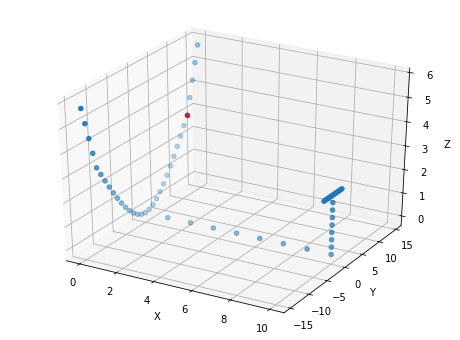

In [17]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
#p = ax.scatter(coordinates[:,0],coordinates[:,1],coordinates[:,2])
p = ax.scatter(xc,yc,zc)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

p2 = ax.scatter(xc[wing_node],yc[wing_node],zc[wing_node],color='red')
plt.show()


Finally we need to store the deflection in some way


In [18]:
print('wing_def =',zc[wing_node])

wing_def = 3.086623269456307


### Obtaining the rotations

In [19]:
print(dataX.structure.timestep_info[0].psi)

[[[ 0.0000000000000000e+00  0.0000000000000000e+00
    0.0000000000000000e+00]
  [ 1.3781507804254677e-16 -1.5083057838858707e-05
    3.9464213240635248e-19]
  [ 6.8907539052082839e-17 -8.0810181245635949e-06
    1.9841038640700836e-19]]

 [[ 1.3781507804254677e-16 -1.5083057838858707e-05
    3.9464213240635248e-19]
  [ 2.7563015530586117e-16 -2.5850200690944598e-05
    7.8012430946761980e-19]
  [ 2.0672261680782406e-16 -2.1006118788710566e-05
    5.8858388953852724e-19]]

 [[ 2.7563015530586117e-16 -2.5850200690944598e-05
    7.8012430946761980e-19]
  [ 4.1344523102307550e-16 -3.2301426432754520e-05
    1.1555557447862645e-18]
  [ 3.4453769339953996e-16 -2.9615303297872115e-05
    9.6915204392424469e-19]]

 [[ 4.1344523102307550e-16 -3.2301426432754520e-05
    1.1555557447862645e-18]
  [ 5.5126030443498878e-16 -3.4436733792213096e-05
    1.5200456537218384e-18]
  [ 4.8235276806499848e-16 -3.3908569954319066e-05
    1.3392240640099515e-18]]

 [[ 0.0000000000000000e+00  0.00000000000000

## Obtaining Lift, Drag and Pitching Moment

In [24]:
aero = dataX.aero.timestep_info[0]

force = aero.total_steady_inertial_forces[:3]
moment= aero.total_steady_inertial_forces[3:]



In [25]:
print(force)
fx = force[0]
fy = force[1]
fz = force[2]

print('fx = ',fx)
print('fy = ',fy)
print('fz = ',fz)

[ 2.6913655253723050e+00 -1.4929724123646793e-13  6.2324534180434080e+02]
fx =  2.691365525372305
fy =  -1.4929724123646793e-13
fz =  623.2453418043408


In [26]:
print(moment)
mx = moment[0]
my = moment[1]
mz = moment[2]

print('mx = ',mx)
print('my = ',my)
print('mz = ',mz)

[ 6.149595400327493e-16  3.492654401655228e+01 -5.189588510652529e-14]
mx =  6.149595400327493e-16
my =  34.92654401655228
mz =  -5.189588510652529e-14
